# Requirements

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Laboratory Exercise - Run Mode (8 points)

## Introduction
In this laboratory assignment, the focus is on time series forecasting, specifically targeting the prediction of the current **mean temperature** in the city of Delhi. Your task involves employing bagging and boosting methods to forecast the **mean temperature**. To accomplish this use data from the preceding three days, consisting of **mean temperature**, **humidity**, **wind speed**, and **mean pressure**.

**Note: You are required to perform this laboratory assignment on your local machine.**

## The Climate Dataset

## Downloading the Climate Dataset

In [1]:
!gdown 1kczX2FpFTH1QEsDeg6dszXM3Azwyd7XC # Download the dataset.

Downloading...
From: https://drive.google.com/uc?id=1kczX2FpFTH1QEsDeg6dszXM3Azwyd7XC
To: /content/climate-data.csv
100% 78.1k/78.1k [00:00<00:00, 2.69MB/s]


## Exploring the Climate Dataset
This dataset consists of daily weather records for the city of Delhi spanning a period of 4 years (from 2013 to 2017). The dataset includes the following attributes:

- date - date in the format YYYY-MM-DD,
- meantemp - mean temperature averaged from multiple 3-hour intervals in a day,
- humidity - humidity value for the day (measured in grams of water vapor per cubic meter volume of air),
- wind_speed - wind speed measured in kilometers per hour, and
- meanpressure - pressure reading of the weather (measured in atm).

*Note: The dataset is complete, with no missing values in any of its entries.*

Load the dataset into a `pandas` data frame.

In [4]:
data = pd.read_csv('climate-data.csv')

Explore the dataset using visualizations of your choice.

In [10]:
data.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [12]:
data['date'] = pd.to_datetime(data['date'])

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1462 non-null   datetime64[ns]
 1   meantemp      1462 non-null   float64       
 2   humidity      1462 non-null   float64       
 3   wind_speed    1462 non-null   float64       
 4   meanpressure  1462 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 57.2 KB


In [18]:
data.set_index('date', inplace=True)

In [22]:
data = data.resample('1D').first()

In [24]:
data.isna().sum()

meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

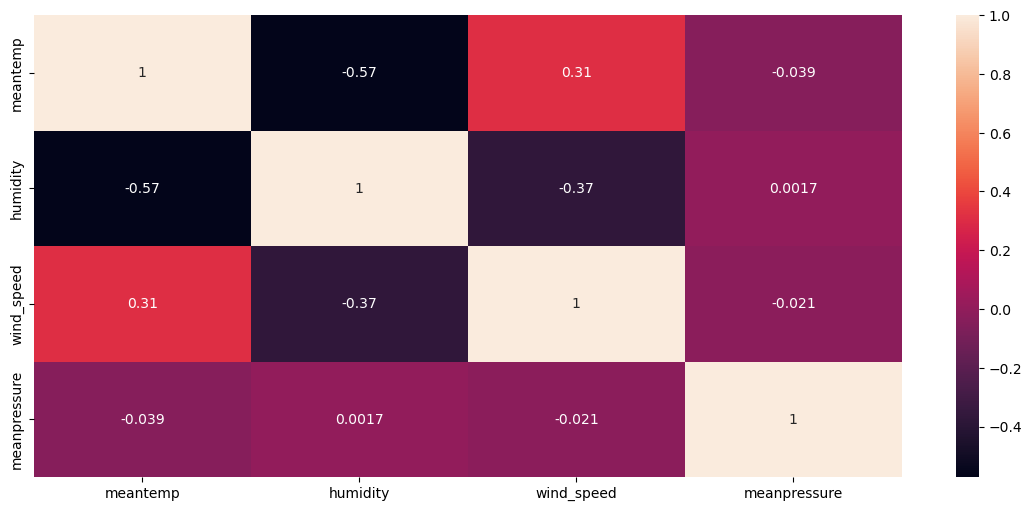

In [26]:
plt.figure(figsize=(14,6))
sns.heatmap(data.corr(), annot=True)
plt.show()

# Feauture Extraction
Apply a lag of one, two, and three days to each feature, creating a set of features representing the meteorological conditions from the previous three days. To maintain dataset integrity, eliminate any resulting missing values at the beginning of the dataset.

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [28]:
data.reset_index(drop=True, inplace=True)
data.head()

,meantemp,humidity,wind_speed,meanpressure
0,10.000000,84.500000,0.000000,1015.666667
1,7.400000,92.000000,2.980000,1017.800000
2,7.166667,87.000000,4.633333,1018.666667
3,8.666667,71.333333,1.233333,1017.166667
4,6.000000,86.833333,3.700000,1016.500000


In [34]:
for feature in data.columns:
    for lag in (1,2,3):
        data[f'{feature}_lag{lag}'] = data[feature].shift(lag)

In [36]:
data.head()

,meantemp,humidity,wind_speed,meanpressure,meantemp_lag1,meantemp_lag2,meantemp_lag3,humidity_lag1,humidity_lag2,humidity_lag3,wind_speed_lag1,wind_speed_lag2,wind_speed_lag3,meanpressure_lag1,meanpressure_lag2,meanpressure_lag3
0,10.000000,84.500000,0.000000,1015.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7.400000,92.000000,2.980000,1017.800000,10.000000,NaN,NaN,84.500000,NaN,NaN,0.000000,NaN,NaN,1015.666667,NaN,NaN
2,7.166667,87.000000,4.633333,1018.666667,7.400000,10.000000,NaN,92.000000,84.5,NaN,2.980000,0.000000,NaN,1017.800000,1015.666667,NaN
3,8.666667,71.333333,1.233333,1017.166667,7.166667,7.400000,10.0,87.000000,92.0,84.5,4.633333,2.980000,0.00,1018.666667,1017.800000,1015.666667
4,6.000000,86.833333,3.700000,1016.500000,8.666667,7.166667,7.4,71.333333,87.0,92.0,1.233333,4.633333,2.98,1017.166667,1018.666667,1017.800000


In [40]:
data.dropna(axis=0, inplace=True)
data.isna().sum()

meantemp             0
humidity             0
wind_speed           0
meanpressure         0
meantemp_lag1        0
meantemp_lag2        0
meantemp_lag3        0
humidity_lag1        0
humidity_lag2        0
humidity_lag3        0
wind_speed_lag1      0
wind_speed_lag2      0
wind_speed_lag3      0
meanpressure_lag1    0
meanpressure_lag2    0
meanpressure_lag3    0
dtype: int64

## Dataset Splitting
Partition the dataset into training and testing sets with an 80:20 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**



In [48]:
from sklearn.model_selection import train_test_split

X = data.drop('meantemp',axis=1)
Y = data['meantemp']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

## Ensemble Learning Methods

### Bagging

Create an instance of a Random Forest model and train it using the `fit` function.

In [58]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X_train, Y_train)

RandomForestRegressor()

Use the trained model to make predictions for the test set.

In [60]:
y_pred = model.predict(X_test)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [64]:
from sklearn.metrics import r2_score

score = r2_score(Y_test, y_pred)
print(f'Score: {score}')

Score: 0.96631250041113


### Boosting

Create an instance of an XGBoost model and train it using the `fit` function.

In [66]:
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(X_train, Y_train)

Use the trained model to make predictions for the test set.

In [68]:
y_pred = model.predict(X_test)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [70]:
print(r2_score(Y_test, y_pred))

0.96631250041113


# Laboratory Exercise - Bonus Task (+ 2 points)

Define the forecasting model using the **Keras Sequential API** (`keras.models.Sequential`), incorporating one or more LSTM layers along with additional relevant layers (`keras.layers`). Be cautious when specifying the configuration of the final layer to ensure proper model output for the forecasting task.